In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
# import seaborn as sns
import itertools
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn import svm
# from sklearn.ensemble import RandomForestClassifier

2023-11-26 06:33:09.431031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [3]:
train['DAYS_EMPLOYED'].skew()

1.7775960013665866

In [4]:
train['income_total'].skew()

2.659270736824145

## **1. 결측치 제거** 

- occpy_type 제거 이유
    - NULL 값을 보여줘야한다. -> R
- FLAG_MOBIL
  - 모두가 1인것을 보여줘야한다

In [5]:
train=train.drop(['index','occyp_type','FLAG_MOBIL'], axis=1)
test=test.drop(['index','occyp_type','FLAG_MOBIL'], axis=1)

### DAY_EMPLOYED 0값 채우기

In [6]:
train[train['DAYS_EMPLOYED']>0]["DAYS_EMPLOYED"] = 0

### 음수 -> 양수

In [7]:
train["DAYS_BIRTH"] = abs(train["DAYS_BIRTH"])
train["DAYS_EMPLOYED"] = abs(train["DAYS_EMPLOYED"])
train["begin_month"] = abs(train["begin_month"])

test["DAYS_BIRTH"] = abs(test["DAYS_BIRTH"])
test["DAYS_EMPLOYED"] = abs(test["DAYS_EMPLOYED"])
test["begin_month"] = abs(test["begin_month"])

### 파생변수

In [8]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [9]:
train['EMPLOYED'] = train['DAYS_EMPLOYED'] // 365 #근속일
train['AGE'] = train['DAYS_BIRTH'] // 365 # 나이
train['income_mean'] = train['income_total'] / train['family_size'] # 소득 비율
train['before_EMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED'] # 고용될때 까지의 날짜
train['income_EMPLOYED'] = train['income_total'] / train['DAYS_EMPLOYED'] # 일하면서 번돈?
train['diff_fam_child'] = train['family_size'] - train['child_num'] # 전체 가족수 - 자식 수 (내 위에 사람들?)

In [10]:
train['personal_id'] = train['gender'] + "_" + train['DAYS_BIRTH'].astype(str) + "_" + train['income_total'].astype(str) + "_" + train['income_type'].astype(str)


In [11]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,credit,EMPLOYED,AGE,income_mean,before_EMPLOYED,income_EMPLOYED,diff_fam_child,personal_id
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,2.0,6.0,1.0,12,38,101250.0,9190,43.002761,2.0,F_13899_202500.0_Commercial associate
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,3.0,5.0,1.0,4,31,82500.0,9840,160.714286,2.0,F_11380_247500.0_Commercial associate
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,...,2.0,22.0,2.0,12,52,225000.0,14653,101.488498,2.0,M_19087_450000.0_Working
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,2.0,37.0,0.0,5,41,101250.0,12996,96.797323,2.0,F_15088_202500.0_Commercial associate
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,...,2.0,26.0,2.0,5,41,78750.0,12932,74.821853,2.0,F_15037_157500.0_State servant


In [12]:
import numpy as np

# 로그 변환할 특성 선택
skewed_features = ['income_total', 'DAYS_EMPLOYED']

# 0이나 음수 값이 없는 경우에만 로그 변환 적용
for feature in skewed_features:
    if (train[feature] > 0).all():
        train[feature] = np.log(train[feature])
        
    if (test[feature] > 0).all():
        test[feature] = np.log(test[feature])

## **2. Binary variables**

- gender, car, reality, income_type, edu_type, family_type, house_type

In [13]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

encoder = LabelEncoder()
encoder = OrdinalEncoder()
bin = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type',"personal_id"]
encoder = OrdinalEncoder()
train[bin] = encoder.fit_transform(train[bin], train['credit'])
# test[bin] = encoder.transform(test[bin])

# for i in bin:
#     print(train[i].value_counts())
#     s = encoder.fit_transform(train[i],train['credit'])
#     train.loc[:,i] = s
#     print(train[i].value_counts())
#     print('-'*10)
#     train[i] = pd.to_numeric(train[i])

In [14]:
# for i in bin:
#     s = encoder.fit_transform(test[i])
#     test.loc[:,i] = s
#     test[i] = pd.to_numeric(test[i])

### 이상치

In [15]:
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train

candidate = ['child_num']
# candidate = ["child_num","income_total","DAYS_BIRTH","DAYS_EMPLOYED","family_size","begin_month"]
for cand in candidate:  
    train = remove_outlier(train,cand)
    

outlier의 수 :  369


<Axes: >

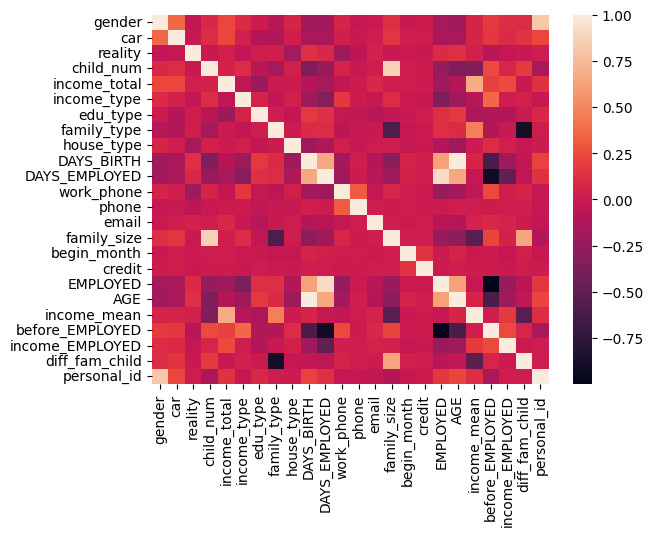

In [16]:
sns.heatmap(train.corr())

In [17]:
# train.to_csv("test2.csv",index = False)

In [18]:
train.drop(["child_num","DAYS_BIRTH",'gender'],axis = 1, inplace = True)

<Axes: >

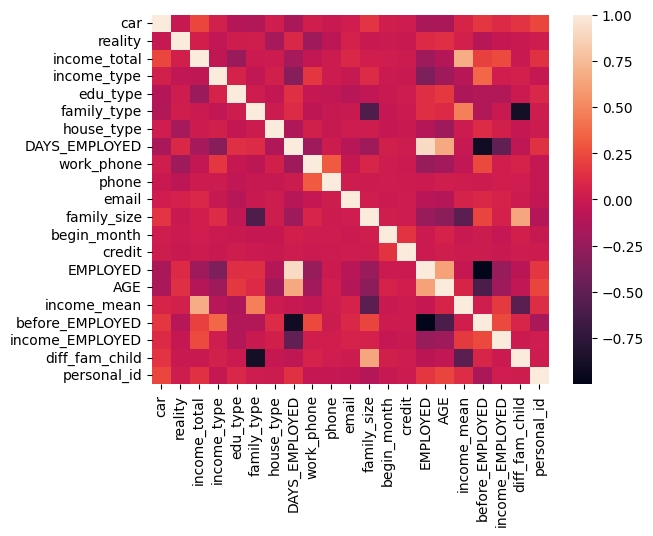

In [19]:
sns.heatmap(train.corr())

### StandardScaler

In [20]:
s = ["begin_month","EMPLOYED","before_EMPLOYED","income_mean","income_EMPLOYED"]
train[s].skew() #income_mean과 income_EMPLOYED의 skew가 높은 것을 볼 수 있다.

begin_month        0.291060
EMPLOYED           1.759379
before_EMPLOYED   -1.758229
income_mean        2.594154
income_EMPLOYED    6.315229
dtype: float64

In [21]:
s = ["begin_month","EMPLOYED"]

In [22]:
from  sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler() #skew가 높은 것을 제외한 것들 정규화
train[s] = scaler.fit_transform(train[s])

In [24]:
if (train["income_mean"] > 0).all():
        train["income_mean"] = np.log(train["income_mean"])

In [25]:
if (train["income_EMPLOYED"] > 0).all():
        train["income_EMPLOYED"] = np.log(train["income_EMPLOYED"])
    

In [26]:
train['income_EMPLOYED'].skew(), train['income_mean'].skew() 

(-1.0666075187916602, 0.15056016138733389)

## 3. Modeling

#### Logistic

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 46)

clf= LogisticRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict_proba(x_test)
log_loss(to_categorical(y_test['credit']),y_pred)

0.8874192353082573

#### XGB

In [28]:
from xgboost import XGBClassifier
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 42)
clf=XGBClassifier()
clf.fit(x_train, y_train)
# y_pred = clf.predict(x_test)
#기본 0.7031368102796675
# accuracy_score(y_test, y_pred) #0.70427059712774(로그 변환), 0.7106170946722883(이상치 제거) # 0.7073591414334994 떨어짐..
y_pred = clf.predict_proba(x_test)
log_loss(to_categorical(y_test['credit']),y_pred)

0.7326513937199086

In [29]:
#0.7570779095141649 (첫번째 노 전처리)
#0.7437512418790037 (이상치 제거)
#0.7326513937199086 (종합..?)

In [46]:
train.iloc[10000].to_list()[:-1]

[1.0,
 0.0,
 12.125404742462718,
 4.0,
 1.0,
 1.0,
 1.0,
 6.8308742346461795,
 1.0,
 0.0,
 0.0,
 4.0,
 -0.7320249671460602,
 2.0,
 -0.46468594302302996,
 34.0,
 10.739110381342828,
 11592.0,
 5.29453050781654,
 2.0]

In [86]:
data_point = np.array(train.iloc[22].to_list()[:11] + train.iloc[22].to_list()[12:])

# 1차원 벡터를 2차원으로 reshape
reshaped_data = data_point.reshape(1, -1)

In [87]:
clf.predict(reshaped_data)

array([2])

In [91]:
train.to_csv("test1.csv",index = False)